# Basic Example for Proxima
Illustrates how a Learned Function Accelerator (LFA) can be used with Proxima to replace a function with a learned surrogate model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from proxima.inference import ScikitLearnInferenceEngine
from proxima.training import TrainingEngine
from proxima.data import InMemoryDataStorage
from proxima.uq import DistanceBasedUQ
from proxima.decorator import lfa
from scipy.integrate import romberg
import numpy as np

## Make an Example Function and Application
Our demonstration application is simple: Integrating a complex function

Making the target function

In [2]:
def ackley(X, a=20, b=0.2, c=2 * np.pi):
    """The Ackley function (http://www.sfu.ca/~ssurjano/ackley.html)
    
    Args:
        X (ndarray): Function to be evaluated
    Returns:
        y (ndarray): Values of the Ackley function
    """
    # Make X an array
    X = np.array(X)
    
    # Get the dimensionality of the problem
    if X.ndim == 0:
        X = X[None, None]
    elif X.ndim == 1:
        X = X[:, None]
    d = X.shape[1]
    return - a * np.exp(-b * np.sqrt(np.sum(X ** 2, axis=1) / d)) \
        - np.exp(np.cos(c * X).sum(axis=1) / d) + a + np.e
assert np.isclose(ackley(0), 0).all()
assert np.isclose(ackley([0]), 0).all()
assert np.isclose(ackley([0]*8), 0).all()

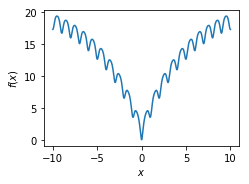

In [3]:
fig, ax = plt.subplots()

# Run the Ackley Function
X = np.linspace(-10, 10, 512)
y = ackley(X)

ax.plot(X, y)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
fig.set_size_inches(3.5, 2.5)

We can use this with Gaussian quadrature to compute the integral

In [4]:
true_result = romberg(ackley, -10, 10)[0]
print('Actual integral: {:.2f}'.format(true_result))

Actual integral: 256.11


## Building a Learned Function Approximator
We need an initial model to create a approximator for this function. For this purpose, we choose K Nearest Neighbors because it does not require tuning hyper parameters as more data is added.

In [5]:
model = KNeighborsRegressor(weights='distance')

Fit to some random points in [7, 10]

In [6]:
points = np.random.uniform(7, 10, 5)[:, None]

In [7]:
model.fit(points, ackley(points))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='distance')

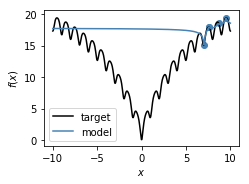

In [8]:
fig, ax = plt.subplots()

# Mark enumeration points
X = np.linspace(-10, 10, 512)[:, None]

# Generate the predictions
y_pred = model.predict(X)
y = ackley(X)

# Plot it all
ax.plot(X, y, 'k', label='target')
ax.scatter(points, ackley(points), color='steelblue')
ax.plot(X, y_pred, color='steelblue', label='model')

ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
fig.set_size_inches(3.5, 2.5)

Note that the function does well on [-7, 10], but has high uncertainities everywhere else

## Build the AI Engine to Run this Approximator
With this model in hand, our next step is to generate a system to use it in place of the Ackley function.

### Step 1: Generate the Engines Supporting the LFA
We need tools to run the approximator, check when the approximator is applicable, collect data from the original function, and retrain the model

Proxima supports of variety of tools that implement differnet strategies for running each of these task. 
We refer to them as "Engines."

### Inference Engine
We can use Proxima's Scikit-Learn adaptor to wrap the model

In [9]:
inference_engine = ScikitLearnInferenceEngine(model)

### UQ Engine
We will use the the distance to the nearest training point as a criterion

In [10]:
uq_engine = DistanceBasedUQ(0.1, metric='euclidean')

### Data Collection Engine
The basic tool in Proxima is to simply store all training data in memory.

In [11]:
data_source = InMemoryDataStorage()

Add the current training data

In [12]:
data_source.add_pairs(points, ackley(points))

### Training Engine
The training engine supports both tools for running the models and different strategies for running the training (e.g., whether to retrain every time)

In [13]:
train_engine = TrainingEngine()

### Step 2: Interpose the Original Function
In Python, we can use wrappers to create the Learned Function Accelerator

In [14]:
lfa_func = lfa(inference_engine, uq_engine, data_source, train_engine)(ackley)

## Test Out the Inference Engine
Run a series of predictions to illustrate the model improving

Call a point from the training set...

In [15]:
x = points[0][0]
y = lfa_func(x)

In [16]:
lfa_func.get_performance_info()

AccelStats(lfa_runs=1, lfa_time=0.0008391000000000002, uq_time=0.0017313, train_time=0, target_runs=0, target_time=0)

... and the LFA invokes the surrogate model

Call a point just outside of that training point...

In [17]:
y = lfa_func(x + 1e-4)
lfa_func.get_performance_info()

AccelStats(lfa_runs=2, lfa_time=0.0019366000000000014, uq_time=0.003458300000000006, train_time=0, target_runs=0, target_time=0)

... and it still invokes the model

Call a point far outside the training data...

In [18]:
y = lfa_func(0)
lfa_func.get_performance_info()

AccelStats(lfa_runs=2, lfa_time=0.0019366000000000014, uq_time=0.004851500000000017, train_time=0.0004261000000000126, target_runs=1, target_time=0.00011909999999998311)

... and it runs the target function and retrains the model

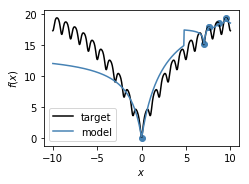

In [19]:
fig, ax = plt.subplots()

# Mark enumeration points
X = np.linspace(-10, 10, 512)[:, None]

# Generate the predictions
y_pred = lfa_func.inference_engine.model.predict(X)
y = ackley(X)

# Get the training points
points, _ = lfa_func.data_source.get_all_data()

# Plot it all
ax.plot(X, y, 'k', label='target')
ax.scatter(points, ackley(points), color='steelblue')
ax.plot(X, y_pred, color='steelblue', label='model')

ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
fig.set_size_inches(3.5, 2.5)

*Finding*: The model has now improved slightly. 

## Using the Function in an Application
We can use this new function to compute the integral

In [20]:
lfa_result = romberg(lfa_func, -10, 10)[0]
print('Computed integral with LFA: {:.2f}'.format(lfa_result))
print('Computed integral with original function: {:.2f}'.format(true_result))
print('Difference: {:.2e}'.format(lfa_result - true_result))

Computed integral with LFA: 256.20
Computed integral with original function: 256.11
Difference: 8.54e-02


C:\Users\ward6\Miniconda3\lib\site-packages\scipy\integrate\quadrature.py:752: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.455629e-02
  AccuracyWarning)


Print out the performance information

In [21]:
perf_info = lfa_func.get_performance_info()
perf_info

AccelStats(lfa_runs=903, lfa_time=0.3762949999999979, uq_time=0.6229363999999994, train_time=0.05053279999999985, target_runs=125, target_time=0.007073699999999239)

In [22]:
print('LFA used {:.2f}% of the time'.format(perf_info.lfa_runs / (perf_info.lfa_runs + perf_info.target_runs) * 100))

LFA used 87.84% of the time


Plot the final model

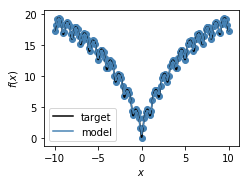

In [23]:
fig, ax = plt.subplots()

# Mark enumeration points
X = np.linspace(-10, 10, 512)[:, None]

# Generate the predictions
y_pred = lfa_func.inference_engine.model.predict(X)
y = ackley(X)

# Get the training points
points, _ = lfa_func.data_source.get_all_data()

# Plot it all
ax.plot(X, y, 'k', label='target')
ax.scatter(points, ackley(points), color='steelblue')
ax.plot(X, y_pred, color='steelblue', label='model')

ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
fig.set_size_inches(3.5, 2.5)